In [ ]:
!pip install simpy

In [ ]:
import simpy
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
from collections import defaultdict


max_time = 1000.0 # мкс

mu_ = [ # шт в мкс
    [100000, 80000, 60000],
    [100000, 80000, 60000],
    [50000, 30000, 15000],
    [20000, 10000, 5000],
    [200000, 100000, 80000],
    [50000, 30000, 10000],
    [20000, 10000, 8000],
]

lambda_ = [100, 50, 50, 200, 200, 100, 50] # шт в сек
lambda_ = [lmbd / 10 ** 6 for lmbd in lambda_] # шт в мкс
densities = [5, 1.5, 1, 2, 0.05, 0.1, 0.05]
sq = 1000

lambda_ = [sq * densities[i] * lambda_[i] for i in range(7)] # шт в мкс всего

# среднее для пуассона в байтах
eta_ = [196, 1401, 4914, 32208, 4559, 914, 3808]

capacities = [1275, 3175, 5575]

color_list = ["#5B9BD5", "#ED7D31", "#70AD47"]

server_weights = [
    [0.6, 0.3, 0.1],
    [0.3, 0.5, 0.2],
    [0.4, 0.3, 0.3],
    [0.4, 0.3, 0.3],
    [0.6, 0.3, 0.1],
    [0.4, 0.3, 0.3],
    [0.6, 0.3, 0.1],
]

routing_matrices = [
    [[0.1, 0.7, 0.2], [0.2, 0.3, 0.5], [0.1, 0.4, 0.5]],
    [[0.1, 0.7, 0.2], [0.2, 0.3, 0.5], [0.1, 0.4, 0.5]],
    [[0.1, 0.6, 0.3], [0.3, 0.3, 0.4], [0.1, 0.3, 0.6]],
    [[0.1, 0.6, 0.3], [0.3, 0.3, 0.4], [0.1, 0.3, 0.6]],
    [[0.1, 0.7, 0.2], [0.2, 0.3, 0.5], [0.1, 0.4, 0.5]],
    [[0.1, 0.6, 0.3], [0.3, 0.3, 0.4], [0.1, 0.4, 0.5]],
    [[0.1, 0.7, 0.2], [0.3, 0.3, 0.4], [0.2, 0.3, 0.5]],
]

input_delays = [1000, 100, 10] # шт в мкс

routing_delays = [ # шт в мкс
    [0, 100, 50],
    [100, 0, 30],
    [50, 30, 0],
]

In [ ]:
class Server:
    def __init__(self, env, id, capacity, color, input_delay, routing_delays):
        self.env = env
        self.id = id
        self.color = color
        self.resource = simpy.Resource(env, capacity=capacity)
        self.input_delay = input_delay
        self.routing_delays = routing_delays
        #self.moving_average = {}
        self.number_of_task = {}

    def process_request(self, stream, request_id, flag):
        input_delay = random.expovariate(self.input_delay)
        if flag:
          stream.request_delays[request_id] += input_delay
          stream.request_plus_process_delays[request_id] += input_delay
          yield self.env.timeout(input_delay)

        with self.resource.request() as req:
          yield req

          self.number_of_task[self.env.now] = self.resource.count
          #self.moving_average[self.env.now] = sum(self.number_of_task.values()) / len(self.number_of_task.values())

          service_time = random.expovariate(stream.mu[self.id])
          number_of_bits = np.random.poisson(stream.eta_)
          service_time *= number_of_bits
          stream.request_plus_process_delays[request_id] += (service_time)
          yield self.env.timeout(service_time)

          self.number_of_task[self.env.now] = self.resource.count
          #self.moving_average[self.env.now] = sum(self.number_of_task.values()) / len(self.number_of_task.values())

          next_server = stream.server_choice(stream.routing_matrix[self.id])
          if next_server != self.id:
              routing_delay = random.expovariate(self.routing_delays[next_server])
              stream.request_delays[request_id] += routing_delay
              stream.request_plus_process_delays[request_id] += routing_delay
              yield self.env.timeout(routing_delay)
              flag = False

              self.env.process(stream.servers[next_server].process_request(stream, request_id, flag))
          else:
              stream.request_delays[request_id] += input_delay
              stream.request_plus_process_delays[request_id] += input_delay
              yield self.env.timeout(input_delay)


class Stream:
    def __init__(
        self,
        env,
        id,
        lambda_,
        eta_,
        mu,
        server_weights,
        density,
        routing_matrix,
        servers
    ):
        self.env = env
        self.id = id
        self.lambda_ = lambda_
        self.eta_ = eta_
        self.mu = mu
        self.server_weights = server_weights
        self.density = density
        self.routing_matrix = routing_matrix
        self.servers = servers
        self.request_delays = {}
        self.request_plus_process_delays = {}
        self.request_counter = itertools.count(1)

    def generate_request(self):
        while True:
            inter_arrival_time = random.expovariate(self.lambda_ * self.density * sq)
            yield self.env.timeout(inter_arrival_time)

            request_id = next(self.request_counter)
            server_id = self.server_choice(self.server_weights)

            self.request_delays[request_id] = 0
            self.request_plus_process_delays[request_id] = 0
            flag = True
            self.env.process(self.servers[server_id].process_request(self, request_id, flag))

    def server_choice(self, probabilities):
        return np.random.choice(3, p=probabilities)


def run_simulation(
    max_time,
    mu_,
    lambda_,
    eta_,
    capacities,
    color_list,
    densities,
    server_weights,
    routing_matrices,
    input_delays,
    routing_delays,
):
    env = simpy.Environment()
    servers = []
    streams = []

    for i, capacity in enumerate(capacities):
        server = Server(
            env,
            i,
            capacity,
            color_list[i],
            input_delays[i],
            routing_delays[i]
        )
        servers.append(server)

    for i, stream_lambda in enumerate(lambda_):
        stream = Stream(
            env,
            i,
            stream_lambda,
            eta_[i],
            mu_[i],
            server_weights[i],
            densities[i],
            routing_matrices[i],
            servers,
        )
        streams.append(stream)
        env.process(stream.generate_request())

    env.run(until=max_time)
    print("All done!")
    return env, servers, streams

In [ ]:
env, servers, streams = run_simulation(
    max_time,
    mu_,
    lambda_,
    eta_,
    capacities,
    color_list,
    densities,
    server_weights,
    routing_matrices,
    input_delays,
    routing_delays
)


All done!


In [ ]:
'''from google.colab import drive
drive.mount('/content/drive')
google_drive_path = "/content/drive/MyDrive/simulation_data_1.pkl"'''

'from google.colab import drive\ndrive.mount(\'/content/drive\')\ngoogle_drive_path = "/content/drive/MyDrive/simulation_data_1.pkl"'

In [ ]:
'''import pickle

def extract_simulation_data(servers, streams):
    server_data = [
        {
            "id": server.id,
            "capacity": server.resource.capacity,
            "color": server.color,
            "input_delay": server.input_delay,
            "routing_delays": server.routing_delays,
            "number_of_task": server.number_of_task,
        }
        for server in servers
    ]

    stream_data = [
        {
            "id": stream.id,
            "lambda_": stream.lambda_,
            "eta_": stream.eta_,
            "mu": stream.mu,
            "server_weights": stream.server_weights,
            "density": stream.density,
            "routing_matrix": stream.routing_matrix,
            "request_delays": stream.request_delays,
            "request_plus_process_delays": stream.request_plus_process_delays,
        }
        for stream in streams
    ]

    return server_data, stream_data

server_data, stream_data = extract_simulation_data(servers, streams)

def save_simulation_to_drive(server_data, stream_data, drive_path):
    with open(drive_path, "wb") as f:
        pickle.dump((server_data, stream_data), f)

save_simulation_to_drive(server_data, stream_data, google_drive_path)'''

'import pickle\n\ndef extract_simulation_data(servers, streams):\n    server_data = [\n        {\n            "id": server.id,\n            "capacity": server.resource.capacity,\n            "color": server.color,\n            "input_delay": server.input_delay,\n            "routing_delays": server.routing_delays,\n            "number_of_task": server.number_of_task,\n        }\n        for server in servers\n    ]\n\n    stream_data = [\n        {\n            "id": stream.id,\n            "lambda_": stream.lambda_,\n            "eta_": stream.eta_,\n            "mu": stream.mu,\n            "server_weights": stream.server_weights,\n            "density": stream.density,\n            "routing_matrix": stream.routing_matrix,\n            "request_delays": stream.request_delays,\n            "request_plus_process_delays": stream.request_plus_process_delays,\n        }\n        for stream in streams\n    ]\n\n    return server_data, stream_data\n\nserver_data, stream_data = extract_simul

In [ ]:
'''def load_simulation_from_drive(drive_path):
    with open(drive_path, "rb") as f:
        server_data, stream_data = pickle.load(f)
    return server_data, stream_data

loaded_servers, loaded_streams = load_simulation_from_drive(google_drive_path)'''

'def load_simulation_from_drive(drive_path):\n    with open(drive_path, "rb") as f:\n        server_data, stream_data = pickle.load(f)\n    return server_data, stream_data\n\nloaded_servers, loaded_streams = load_simulation_from_drive(google_drive_path)'

In [ ]:
def plot_results(server, max_time):

    my_list = [item / capacities[server.id] for item in list(server.number_of_task.values())]

    plt.rcParams['font.size'] = '14'


    plt.plot(
        list(server.number_of_task.keys()),
        my_list,
        label="Случайный процесс",
        color=server.color,
        alpha=0.5,
    )
    plt.axhline(
        (np.mean(my_list)),
        color=server.color,
        linestyle="-",
        linewidth=1,
        label="Эмпирическое среднее",
    )
    plt.xlim(0, max_time)
    plt.ylim(0, 1)
    plt.grid(linestyle="--", alpha=0.5)
    plt.xlabel("Время")
    plt.ylabel("Загрузка узла")
    plt.legend(loc=4)
    plt.show()

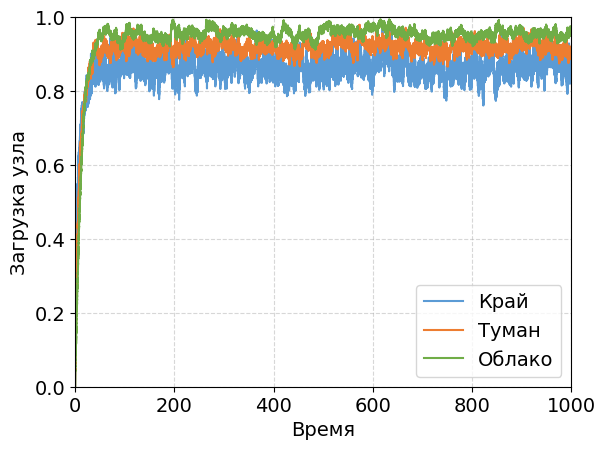

In [ ]:
label_list = ['Край','Туман','Облако']
for i, server in enumerate(servers):
    my_list = [item / capacities[server.id] for item in list(server.number_of_task.values())]

    plt.rcParams['font.size'] = '14'


    plt.plot(
        list(server.number_of_task.keys()),
        my_list,
        color=server.color,
        label=label_list[i]
    )
plt.xlim(0, max_time)
plt.ylim(0, 1)
plt.grid(linestyle="--", alpha=0.5)
plt.xlabel("Время")
plt.ylabel("Загрузка узла")
plt.legend(loc=4)
plt.savefig('load.png')
plt.show()

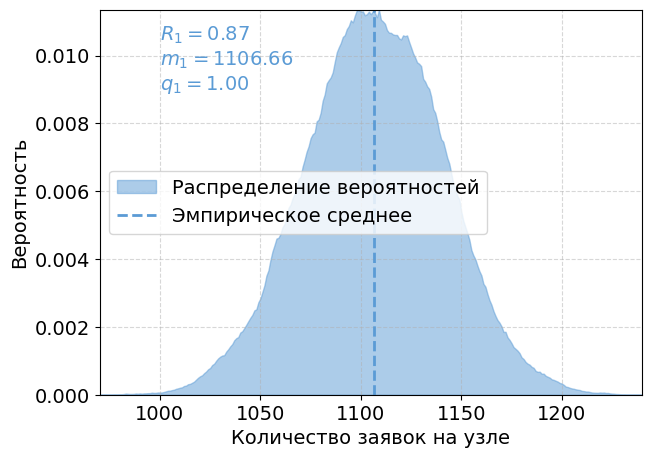

In [ ]:
for server in servers[:1]:
    threshold = 50.0
    not_50 = {k: v for k, v in server.number_of_task.items() if k >= threshold}
    state_durations = defaultdict(float)
    sorted_keys = sorted(not_50.keys())
    for i in range(len(sorted_keys) - 1):
      current_time = sorted_keys[i]
      next_time = sorted_keys[i + 1]

      interval_duration = next_time - current_time

      current_state = not_50[current_time]

      state_durations[current_state] += interval_duration
    total_duration = sum(state_durations.values())

    state_probabilities = {k: v / total_duration for k, v in state_durations.items()}

    empirical_mean = sum(x * p for x, p in state_probabilities.items())

    resource_utilization = empirical_mean / server.resource.capacity

    available_intervals = [v < server.resource.capacity for v in not_50.values()]
    availability = sum(available_intervals) / len(available_intervals)

    state_probabilities = dict(sorted(state_probabilities.items()))
    states = list(state_probabilities.keys())
    probabilities = list(state_probabilities.values())

    plt.figure(figsize=(7, 5))
    plt.fill_between(states, probabilities, linestyle='-', color=server.color, alpha=0.5, label='Распределение вероятностей')
    plt.axvline(empirical_mean, color=server.color, linestyle='--', linewidth=2, label='Эмпирическое среднее')
    plt.xlabel('Количество заявок на узле')
    plt.ylabel('Вероятность')
    plt.ylim(0,max(probabilities))
    plt.xlim(min(states),max(states))
    plt.legend(loc=6)
    plt.text(1000, 0.009, f'$R_{server.id+1}={resource_utilization:.2f}$\n$m_{server.id+1}={empirical_mean:.2f}$\n$q_{server.id+1}={availability:.2f}$', color=server.color)
    plt.grid(linestyle='--',alpha=0.5)
    plt.savefig(f'prob{server.id}.png')
    plt.show()

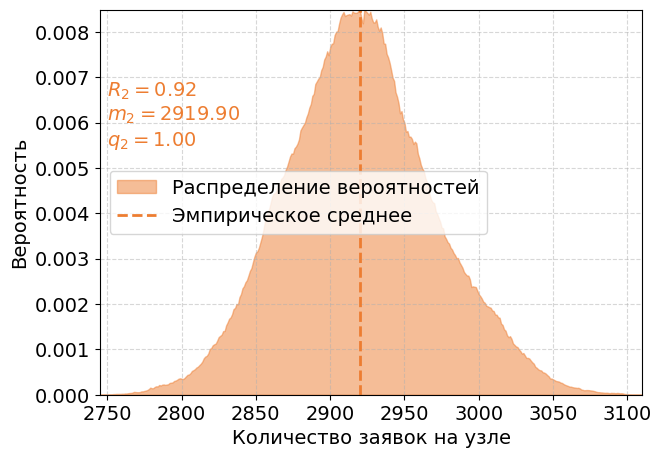

In [ ]:
for server in servers[1:2]:
    threshold = 50.0
    not_50 = {k: v for k, v in server.number_of_task.items() if k >= threshold}
    state_durations = defaultdict(float)
    sorted_keys = sorted(not_50.keys())
    for i in range(len(sorted_keys) - 1):
      current_time = sorted_keys[i]
      next_time = sorted_keys[i + 1]

      interval_duration = next_time - current_time

      current_state = not_50[current_time]

      state_durations[current_state] += interval_duration
    total_duration = sum(state_durations.values())

    state_probabilities = {k: v / total_duration for k, v in state_durations.items()}

    empirical_mean = sum(x * p for x, p in state_probabilities.items())

    resource_utilization = empirical_mean / server.resource.capacity

    available_intervals = [v < server.resource.capacity for v in not_50.values()]
    availability = sum(available_intervals) / len(available_intervals)

    state_probabilities = dict(sorted(state_probabilities.items()))
    states = list(state_probabilities.keys())
    probabilities = list(state_probabilities.values())

    plt.figure(figsize=(7, 5))
    plt.fill_between(states, probabilities, linestyle='-', color=server.color, alpha=0.5, label='Распределение вероятностей')
    plt.axvline(empirical_mean, color=server.color, linestyle='--', linewidth=2, label='Эмпирическое среднее')
    plt.xlabel('Количество заявок на узле')
    plt.ylabel('Вероятность')
    plt.ylim(0,max(probabilities))
    plt.xlim(min(states),max(states))
    plt.legend(loc=6)
    plt.text(2750, 0.0055, f'$R_{server.id+1}={resource_utilization:.2f}$\n$m_{server.id+1}={empirical_mean:.2f}$\n$q_{server.id+1}={availability:.2f}$', color=server.color)
    plt.grid(linestyle='--',alpha=0.5)
    plt.savefig(f'prob{server.id}.png')
    plt.show()

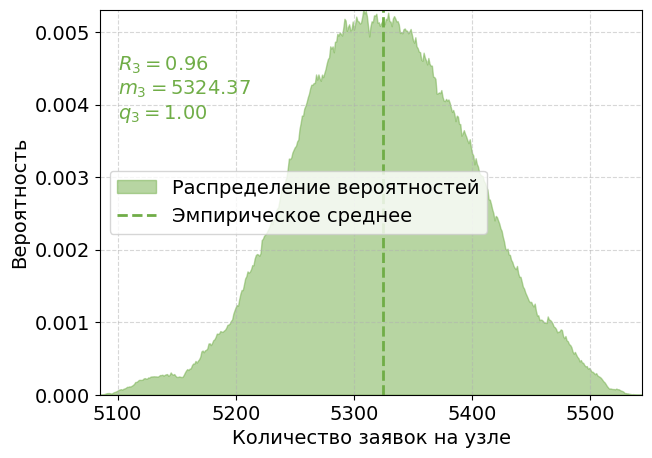

In [ ]:
for server in servers[2:]:
    threshold = 50.0
    not_50 = {k: v for k, v in server.number_of_task.items() if k >= threshold}
    state_durations = defaultdict(float)
    sorted_keys = sorted(not_50.keys())
    for i in range(len(sorted_keys) - 1):
      current_time = sorted_keys[i]
      next_time = sorted_keys[i + 1]

      interval_duration = next_time - current_time

      current_state = not_50[current_time]

      state_durations[current_state] += interval_duration
    total_duration = sum(state_durations.values())

    state_probabilities = {k: v / total_duration for k, v in state_durations.items()}

    empirical_mean = sum(x * p for x, p in state_probabilities.items())

    resource_utilization = empirical_mean / server.resource.capacity

    available_intervals = [v < server.resource.capacity for v in not_50.values()]
    availability = sum(available_intervals) / len(available_intervals)

    state_probabilities = dict(sorted(state_probabilities.items()))
    states = list(state_probabilities.keys())
    probabilities = list(state_probabilities.values())

    plt.figure(figsize=(7, 5))
    plt.fill_between(states, probabilities, linestyle='-', color=server.color, alpha=0.5, label='Распределение вероятностей')
    plt.axvline(empirical_mean, color=server.color, linestyle='--', linewidth=2, label='Эмпирическое среднее')
    plt.xlabel('Количество заявок на узле')
    plt.ylabel('Вероятность')
    plt.ylim(0,max(probabilities))
    plt.xlim(min(states),max(states))
    plt.legend(loc=6)
    plt.text(5100, 0.0038, f'$R_{server.id+1}={resource_utilization:.2f}$\n$m_{server.id+1}={empirical_mean:.2f}$\n$q_{server.id+1}={availability:.2f}$', color=server.color)
    plt.grid(linestyle='--',alpha=0.5)
    plt.savefig(f'prob{server.id}.png')
    plt.show()

In [ ]:
#def take(n, iterable):
#    return list(islice(iterable, n))
#
#n_items = take(5, not_50.items())
#print(n_items)

In [ ]:
def calculate_average_delays(delays_dict):
    if not delays_dict:
        return None
    total_delay = sum(delays_dict.values())
    total_requests = len(delays_dict)
    return total_delay / total_requests

In [ ]:
stream_averages = {}
for stream in streams:
    avg_request_delay = calculate_average_delays(stream.request_delays)
    avg_plus_process_delay = calculate_average_delays(stream.request_plus_process_delays)
    stream_averages[stream.id] = (avg_request_delay, avg_plus_process_delay)

In [ ]:
import math

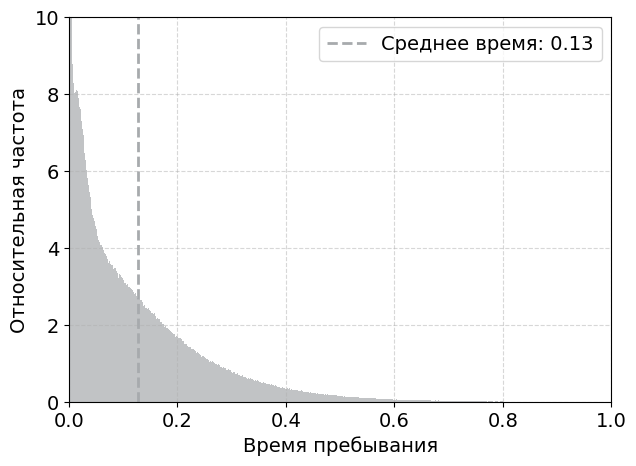

In [ ]:
for stream in streams[:1]:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(7, 5))
    plt.hist(plus_process_delays, bins=int(math.sqrt(len(plus_process_delays))), alpha=0.7, color='#a7aaad', density=True)
    plt.axvline(avg_plus_process_delay, color='#a7aaad', linestyle='--', linewidth=2, label=f'Среднее время: {avg_plus_process_delay:.2f}')
    plt.xlabel('Время пребывания')
    plt.ylabel('Относительная частота')
    plt.xlim(0,1)
    plt.ylim(0,10)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.savefig(f'stream{stream.id}.png')
    plt.show()

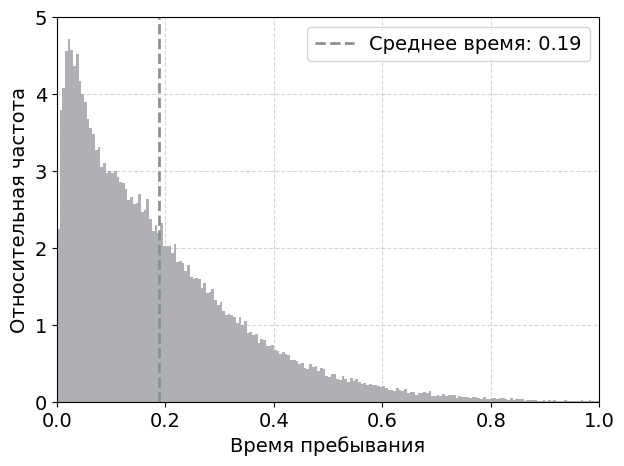

In [ ]:
for stream in streams[1:2]:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(7, 5))
    plt.hist(plus_process_delays, bins=int(math.sqrt(len(plus_process_delays))), alpha=0.7, color='#8c8f94', density=True)
    plt.axvline(avg_plus_process_delay, color='#8c8f94', linestyle='--', linewidth=2, label=f'Среднее время: {avg_plus_process_delay:.2f}')
    plt.xlabel('Время пребывания')
    plt.ylabel('Относительная частота')
    plt.xlim(0,1)
    plt.ylim(0,5)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.savefig(f'stream{stream.id}.png')
    plt.show()

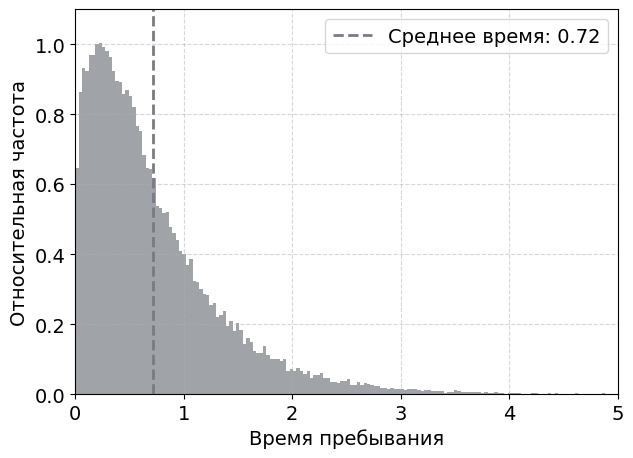

In [ ]:
for stream in streams[2:3]:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(7, 5))
    plt.hist(plus_process_delays, bins=int(math.sqrt(len(plus_process_delays))), alpha=0.7, color='#787c82', density=True)
    plt.axvline(avg_plus_process_delay, color='#787c82', linestyle='--', linewidth=2, label=f'Среднее время: {avg_plus_process_delay:.2f}')
    plt.xlabel('Время пребывания')
    plt.ylabel('Относительная частота')
    plt.xlim(0,5)
    plt.ylim(0,1.1)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.savefig(f'stream{stream.id}.png')
    plt.show()

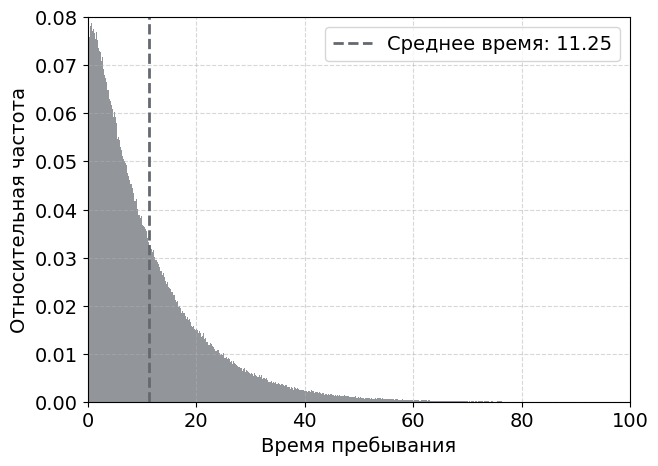

In [ ]:
for stream in streams[3:4]:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(7, 5))
    plt.hist(plus_process_delays, bins=int(math.sqrt(len(plus_process_delays))), alpha=0.7, color='#646970', density=True)
    plt.axvline(avg_plus_process_delay, color='#646970', linestyle='--', linewidth=2, label=f'Среднее время: {avg_plus_process_delay:.2f}')
    plt.xlabel('Время пребывания')
    plt.ylabel('Относительная частота')
    plt.xlim(0,100)
    plt.ylim(0,0.08)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.savefig(f'stream{stream.id}.png')
    plt.show()

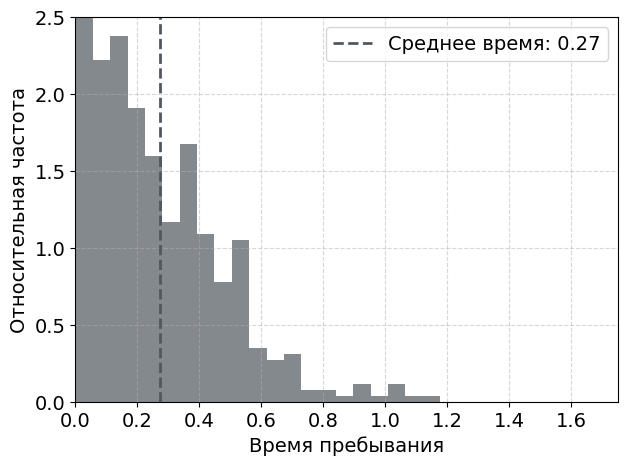

In [ ]:
for stream in streams[4:5]:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(7, 5))
    plt.hist(plus_process_delays, bins=int(math.sqrt(len(plus_process_delays))), alpha=0.7, color='#50575e', density=True)
    plt.axvline(avg_plus_process_delay, color='#50575e', linestyle='--', linewidth=2, label=f'Среднее время: {avg_plus_process_delay:.2f}')
    plt.xlabel('Время пребывания')
    plt.ylabel('Относительная частота')
    plt.xlim(0,1.75)
    plt.ylim(0,2.5)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.savefig(f'stream{stream.id}.png')
    plt.show()

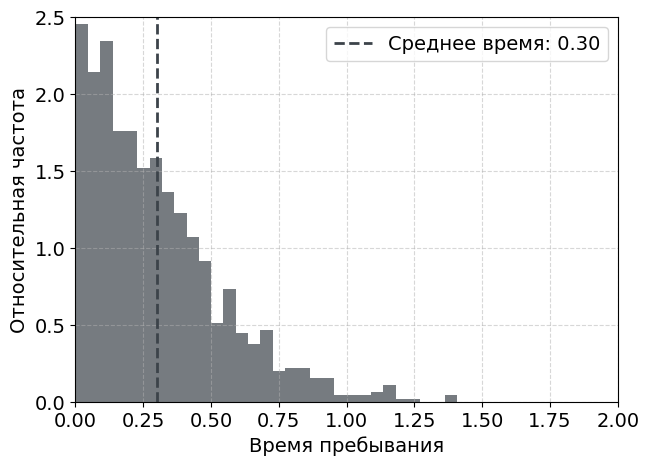

In [ ]:
for stream in streams[5:6]:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(7, 5))
    plt.hist(plus_process_delays, bins=int(math.sqrt(len(plus_process_delays))), alpha=0.7, color='#3c434a', density=True)
    plt.axvline(avg_plus_process_delay, color='#3c434a', linestyle='--', linewidth=2, label=f'Среднее время: {avg_plus_process_delay:.2f}')
    plt.xlabel('Время пребывания')
    plt.ylabel('Относительная частота')
    plt.xlim(0,2)
    plt.ylim(0,2.5)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.savefig(f'stream{stream.id}.png')
    plt.show()

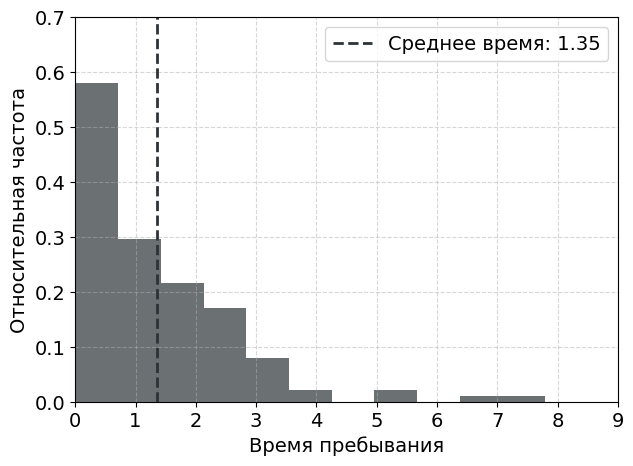

In [ ]:
for stream in streams[6:]:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(7, 5))
    plt.hist(plus_process_delays, bins=int(math.sqrt(len(plus_process_delays))), alpha=0.7, color='#2c3338', density=True)
    plt.axvline(avg_plus_process_delay, color='#2c3338', linestyle='--', linewidth=2, label=f'Среднее время: {avg_plus_process_delay:.2f}')
    plt.xlabel('Время пребывания')
    plt.ylabel('Относительная частота')
    plt.xlim(0,9)
    plt.ylim(0,0.7)
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(loc=1)
    plt.savefig(f'stream{stream.id}.png')
    plt.show()

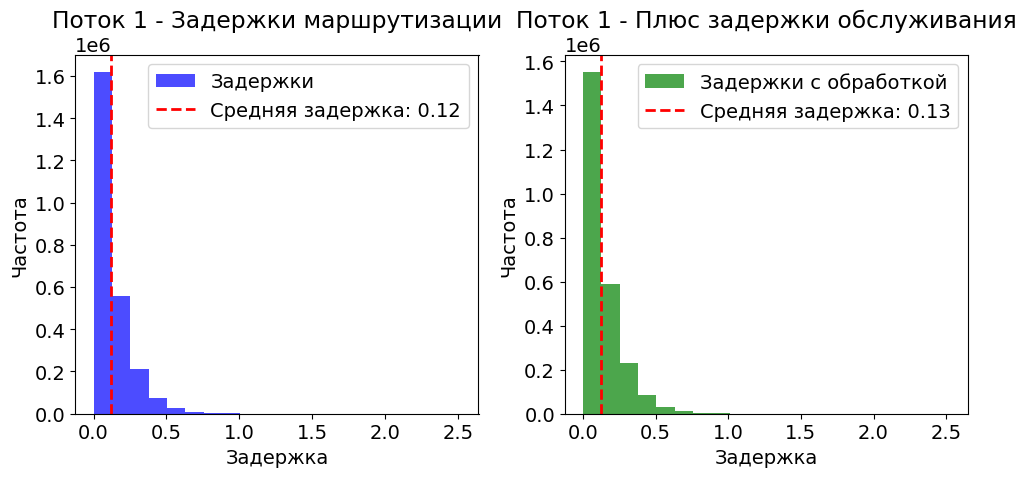

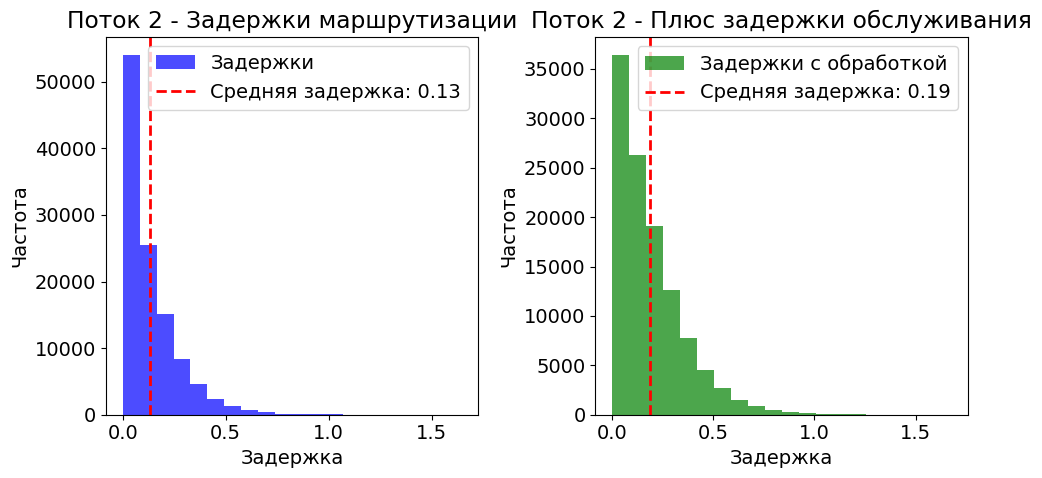

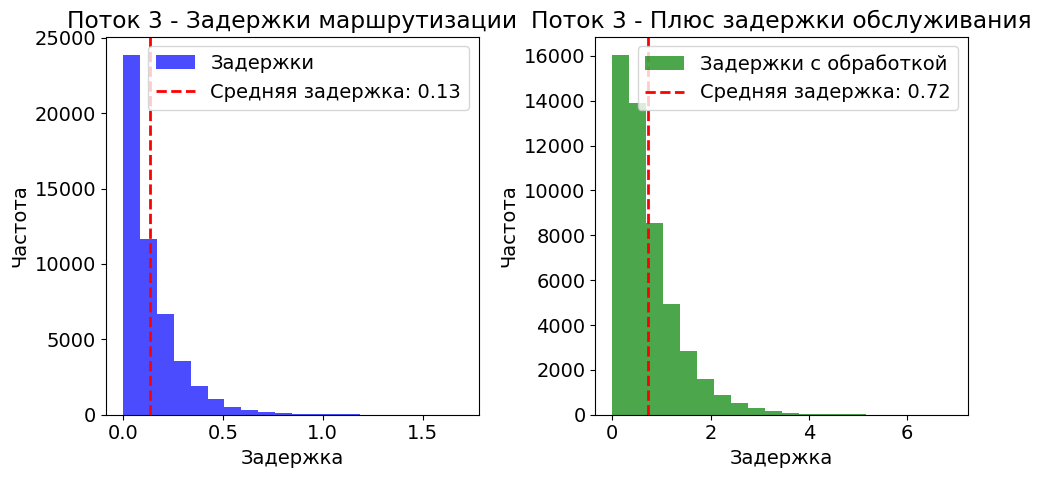

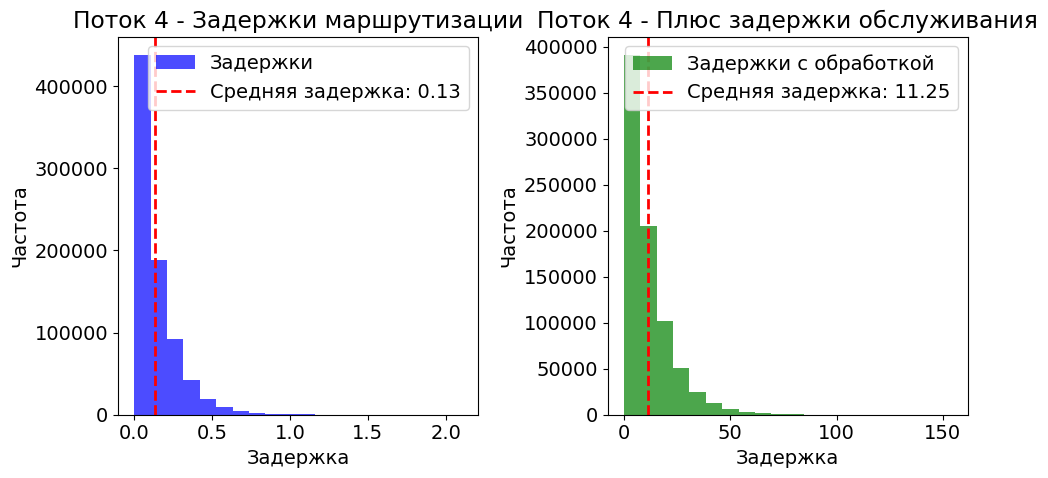

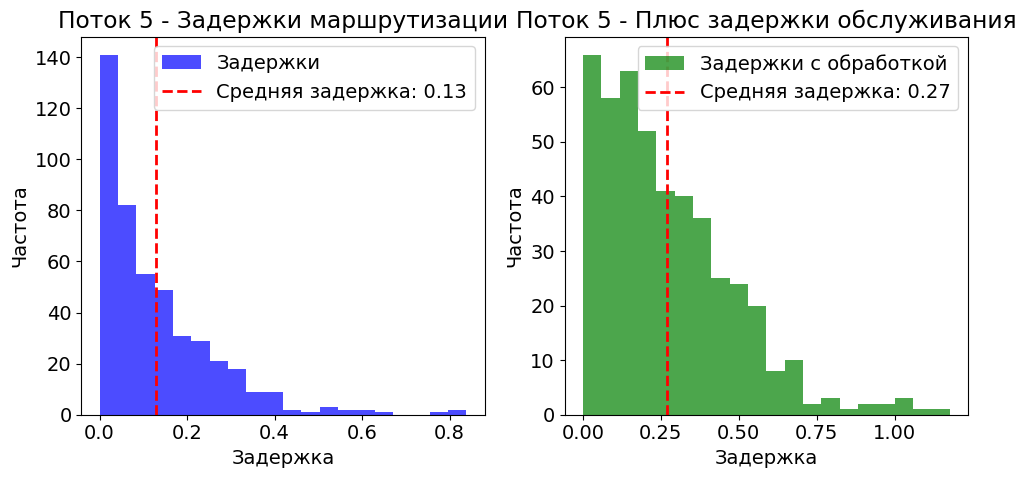

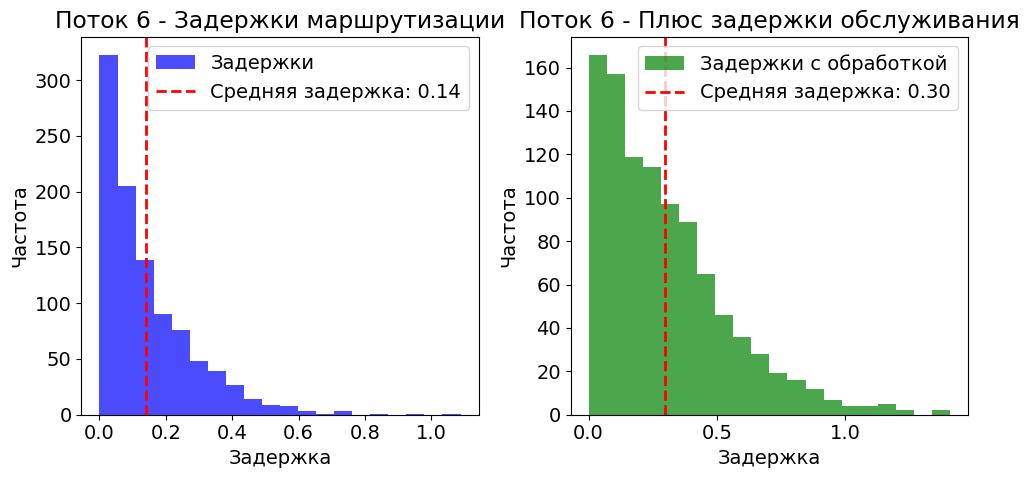

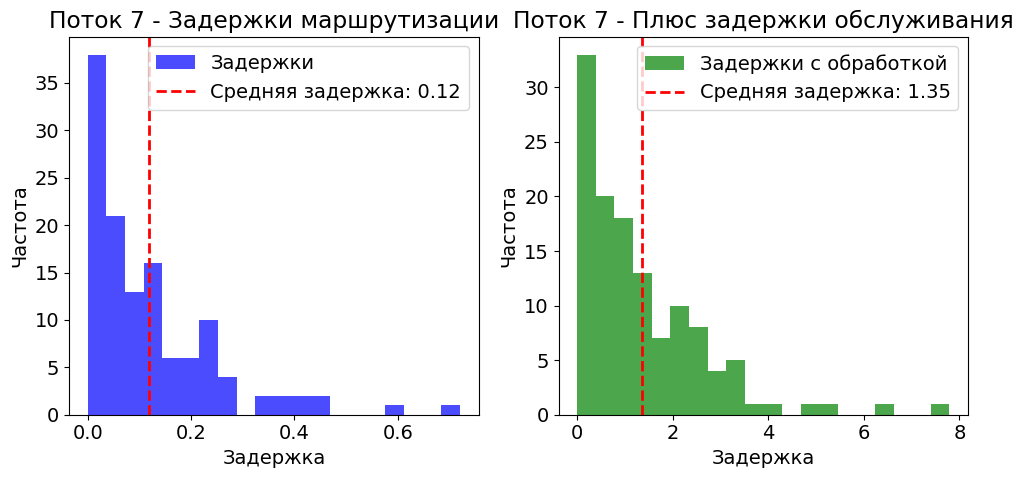

In [ ]:
for stream in streams:
    request_delays = list(stream.request_delays.values())
    plus_process_delays = list(stream.request_plus_process_delays.values())

    avg_request_delay, avg_plus_process_delay = stream_averages[stream.id]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.hist(request_delays, bins=20, alpha=0.7, color='blue', label='Задержки')
    plt.axvline(avg_request_delay, color='r', linestyle='--', linewidth=2, label=f'Средняя задержка: {avg_request_delay:.2f}')
    plt.xlabel('Задержка')
    plt.ylabel('Частота')
    plt.title(f'Поток {stream.id + 1} - Задержки маршрутизации')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(plus_process_delays, bins=20, alpha=0.7, color='green', label='Задержки с обработкой')
    plt.axvline(avg_plus_process_delay, color='r', linestyle='--', linewidth=2, label=f'Средняя задержка: {avg_plus_process_delay:.2f}')
    plt.xlabel('Задержка')
    plt.ylabel('Частота')
    plt.title(f'Поток {stream.id + 1} - Плюс задержки обслуживания')
    plt.legend()

    plt.tight_layout()

    plt.show()